# Clothes Recommendation System (DenseNet121)

Bulding Clothes Recommendation System using DenseNet121

Importing libraries

In [2]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import keras.api._v2.keras as keras
from keras import Model
from keras.applications import DenseNet121
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

In [10]:
path = 'fashion-dataset/'
dataset_path = pathlib.Path(path)
images=os.listdir(dataset_path)
images

['images', 'myntradataset', 'styles.csv']

Showing 10 images in dataset

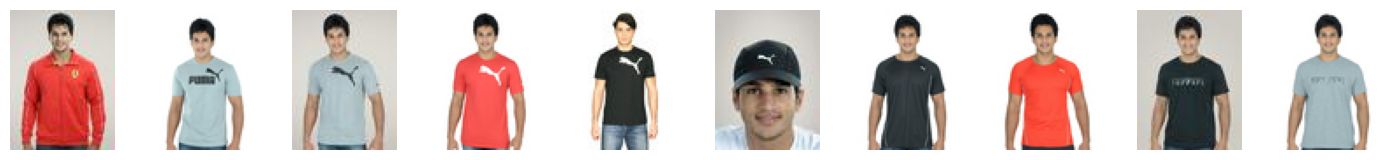

In [11]:
plt.figure(figsize=(20,20))
for i in range(1530, 1540):
    plt.subplot(6, 10, i-1530+1)
    cloth_img =  mpimg.imread(path + 'images/'+ str(i) +'.jpg')
    plt.imshow(cloth_img)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

DataFrame with categories and adding column of image names

In [13]:
df = pd.read_csv(path + "styles.csv", nrows=6000)
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
print(df.shape)
df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [25]:
df.shape

(6000, 11)

Setting the Pre-Trained model DenseNet121

In [14]:
#image dim
img_width, img_height, chnl = 200, 200, 3

# DenseNet121
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnl))
densenet.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    densenet,
    GlobalMaxPooling2D()
])

model.summary()

29084464/29084464 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 6, 6, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 7037504 (26.85 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


Function of model prediction

In [15]:
def img_path(img):
    return path + 'images/' + img
def model_predict(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Building data frame of model prediction for all our images from dataset (getting embedding for all items in dataset)

In [16]:
df_copy      = df
df_embedding = df_copy['image'].apply(lambda x: model_predict(model, x))
df_embedding        = df_embedding.apply(pd.Series)
df_embedding.head(5)

1/1 [==============================] - 1s 583ms/step


C:\Users\Anouska\AppData\Local\Temp\ipykernel_24220\3141068896.py:3: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df_embedding        = df_embedding.apply(pd.Series)


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.001556,0.007687,0.020599,0.019267,0.449369,2.049439,0.003887,0.008508,1.460711,0.001700,...,2.131034,0.796650,16.824625,0.830860,0.729805,0.751430,4.352161,2.216876,6.884370,4.443490
1,0.001270,0.033970,0.010328,0.018846,0.534164,1.102738,0.001283,0.009292,1.386438,0.000774,...,0.351496,6.866708,10.786263,6.283560,2.486138,4.042779,6.910814,0.906824,2.356662,1.481575
2,0.001749,0.009188,0.014581,0.007122,0.568847,1.369895,0.002457,0.003840,0.607830,0.000701,...,2.888706,7.010268,4.313012,1.585577,3.094143,0.225646,7.055238,4.394617,16.545858,1.425255
3,0.000788,0.019114,0.013595,0.017823,0.529423,2.502742,0.001060,0.010470,1.192753,0.001702,...,0.276013,0.000000,14.582143,4.909044,0.243702,4.130859,2.814876,0.500818,0.626905,1.440793
4,0.001572,0.012700,0.014415,0.014550,0.431777,1.308466,0.002086,0.011448,1.112463,0.001078,...,0.312272,1.817061,15.469975,3.959399,0.000000,0.694537,3.778373,6.004061,2.014091,2.263582


In [17]:
df_embedding.to_csv('embeddings_data.csv', index=False)

Computing a cosine similarity to calculate a numeric quantity that denotes the similarity between two images. It is relatively easy and fast to calculate.

In [18]:
cosine_sim = linear_kernel(df_embedding, df_embedding)

Getting indices

In [19]:
indices = pd.Series(range(len(df)), index=df.index)

Getting recommendations using the cosine similarity

In [20]:
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]

    # Get the pairwsie similarity scores of all clothes with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['image'].iloc[cloth_indices]

Checking the result 

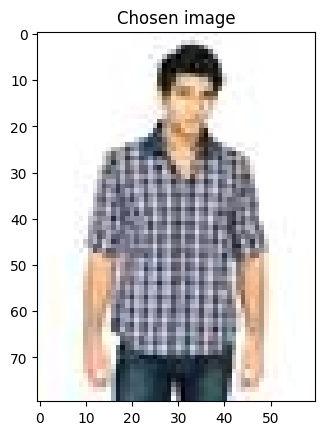

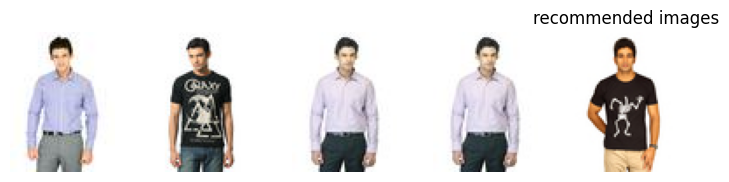

In [30]:
chosen_img_indx = 0

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + 'images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

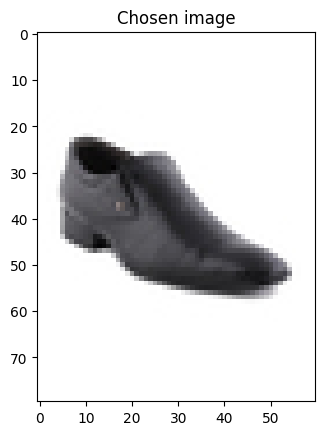

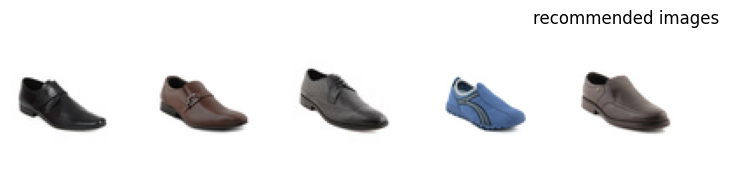

In [29]:
chosen_img_indx = 1533

recommendation = get_recommendations(chosen_img_indx, df, cosine_sim)
recommendation_list = recommendation.to_list()
#chosen image
chosen_img =  mpimg.imread(path + 'images/' + df.iloc[chosen_img_indx].image)
plt.title("Chosen image")
plt.imshow(chosen_img)
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("recommended images")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [23]:
model.save('keras_model.h5')

c:\Users\Anouska\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
